# Artificial Intelligence
# 464
# Project #5

## Before You Begin...
00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, and
02.  Check the submission deadline on Gradescope.


## General Directions for this Assignment
00. Output format should be exactly as requested,
01. Functions should do only one thing.


## Before You Submit...
00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.

## Neural Networks: Architecture

For this assignment we will explore Neural Networks; in particular, we are going to explore model complexity. The goal is classify a mushroom as either edible ('e') or poisonous ('p'). The dataset has been uploaded to Canvas. In case you'd like to learn more about it, here's the link to the repo: https://archive.ics.uci.edu/dataset/73/mushroom. Use PyTorch (https://pytorch.org/) to explore different model complexities (i.e., architectures) before declaring a winner. Either start with a simple network and make it more complex; or start with a complex model and pare it down. Either way, your submission should clearly demonstrate your exploration. 

More specifically: 

* Try three different models, 
* Use cross validation to compare the models, 
* Report the winning model's performance on test data (this is the only time you will use test data), 
* Include a table comparing the three models, 
* Document your process: what the results were, how the winning model was determined, loss function, activation, etc.

Information on cross validation: https://scikit-learn.org/stable/modules/cross_validation.html (notice how final evaluation is the only time test data is used). No other directions for this assignment other than what's here and in the "General Directions" section. You have a lot of freedom with this assignment. Don't get carried away. It is expected the results may vary, being better or worse, due to the limitations of the dataset. Graders are not going to run your notebooks. The notebook will be read as a report on how different models were explored. Since you'll be using libraries, the emphasis will be on your ability to communicate your findings.

In [1]:
!pip3 install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.13 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

dt = pd.read_csv('agaricus-lepiota.data', header=None)
cols = ['class'] + [f'f_{i}' for i in range(1, dt.shape[1])]
dt.columns = cols

le = LabelEncoder()
y = le.fit_transform(dt['class'])

X = pd.get_dummies(dt.drop('class', axis=1), drop_first=False)

xTv, xTs, yTv, yTs = train_test_split(X, y, test_size=0.15, random_state=42)
xTr, xVl, yTr, yVl = train_test_split(xTv, yTv, test_size=0.15/0.85, random_state=42)

xTrT = torch.FloatTensor(xTr.values)
yTrT = torch.LongTensor(yTr)
xVlT = torch.FloatTensor(xVl.values)
yVlT = torch.LongTensor(yVl)
xTsT = torch.FloatTensor(xTs.values)
yTsT = torch.LongTensor(yTs)

class Level1(nn.Module):
    def __init__(self, inSz):
        super(Level1, self).__init__()
        self.fc1 = nn.Linear(inSz, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sig(x)
        return x

class Level2(nn.Module):
    def __init__(self, inSz):
        super(Level2, self).__init__()
        self.fc1 = nn.Linear(inSz, 64)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sig(x)
        return x

class Level3(nn.Module):
    def __init__(self, inSz):
        super(Level3, self).__init__()
        self.fc1 = nn.Linear(inSz, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sig(x)
        return x

def trainMod(mdl, xTr, yTr, xVl, yVl, crt, opt, nEp=10, bSz=32):
    trDs = TensorDataset(xTr, yTr.float().view(-1, 1))
    trLd = DataLoader(trDs, batch_size=bSz, shuffle=True)
    
    trLs = []
    vlLs = []
    trAcs = []
    vlAcs = []
    
    for ep in range(nEp):
        mdl.train()
        epLs = 0
        for ins, tgs in trLd:
            opt.zero_grad()
            outs = mdl(ins)
            ls = crt(outs, tgs)
            ls.backward()
            opt.step()
            epLs += ls.item()
        
        epLs /= len(trLd)
        trLs.append(epLs)
        
        trAc, _, _, _ = evalMod(mdl, xTr, yTr)
        vlAc, _, _, _ = evalMod(mdl, xVl, yVl)
        
        trAcs.append(trAc)
        vlAcs.append(vlAc)
        
        mdl.eval()
        with torch.no_grad():
            vlOuts = mdl(xVl)
            vlL = crt(vlOuts, yVl.float().view(-1, 1)).item()
            vlLs.append(vlL)
    
    return trLs, vlLs, trAcs, vlAcs

def evalMod(mdl, X, y):
    mdl.eval()
    with torch.no_grad():
        outs = mdl(X)
        pred = (outs.data > 0.5).float()
        acc = (pred == y.float().view(-1, 1)).sum().item() / y.size(0)
        
        yT = y.numpy()
        yP = pred.numpy().flatten()
        
        prec = precision_score(yT, yP)
        rec = recall_score(yT, yP)
        f1 = f1_score(yT, yP)
        
    return acc, prec, rec, f1

def crossVal(mCls, X, y, inSz, nSp=5, nEp=10, bSz=32, lr=0.001):
    kf = KFold(n_splits=nSp, shuffle=True, random_state=42)
    
    fAcs = []
    fPrs = []
    fRcs = []
    fF1s = []
    
    eTrAcs = [[] for _ in range(nEp)]
    eVlAcs = [[] for _ in range(nEp)]
    eTrLs = [[] for _ in range(nEp)]
    eVlLs = [[] for _ in range(nEp)]
    ePrs = [[] for _ in range(nEp)]
    eRcs = [[] for _ in range(nEp)]
    eF1s = [[] for _ in range(nEp)]
    
    fd = 1
    for trIdx, vlIdx in kf.split(X):
        xTrF, xVlF = X[trIdx], X[vlIdx]
        yTrF, yVlF = y[trIdx], y[vlIdx]
        
        mdl = mCls(inSz)
        
        crt = nn.BCELoss()
        opt = optim.Adam(mdl.parameters(), lr=lr)
        
        trLs, vlLs, trAcs, vlAcs = trainMod(
            mdl, xTrF, yTrF, xVlF, yVlF, 
            crt, opt, nEp, bSz)
        
        epMetrics = []
        for ep in range(nEp):
            epMdl = mCls(inSz)
            epOpt = optim.Adam(epMdl.parameters(), lr=lr)
            trainMod(epMdl, xTrF, yTrF, xVlF, yVlF, crt, epOpt, ep+1, bSz)
            
            _, pr, rc, f1 = evalMod(epMdl, xVlF, yVlF)
            
            ePrs[ep].append(pr)
            eRcs[ep].append(rc)
            eF1s[ep].append(f1)
        
        for ep in range(nEp):
            eTrAcs[ep].append(trAcs[ep])
            eVlAcs[ep].append(vlAcs[ep])
            eTrLs[ep].append(trLs[ep])
            eVlLs[ep].append(vlLs[ep])
        
        acc, prec, rec, f1 = evalMod(mdl, xVlF, yVlF)
        
        fAcs.append(acc)
        fPrs.append(prec)
        fRcs.append(rec)
        fF1s.append(f1)
        
        fd += 1
    
    aAcc = np.mean(fAcs)
    aPrc = np.mean(fPrs)
    aRec = np.mean(fRcs)
    aF1 = np.mean(fF1s)
    
    aeTrAcs = [np.mean(acs) for acs in eTrAcs]
    aeVlAcs = [np.mean(acs) for acs in eVlAcs]
    aeTrLs = [np.mean(lss) for lss in eTrLs]
    aeVlLs = [np.mean(lss) for lss in eVlLs]
    aePrs = [np.mean(prs) for prs in ePrs]
    aeRcs = [np.mean(rcs) for rcs in eRcs]
    aeF1s = [np.mean(f1s) for f1s in eF1s]
    
    eMtrs = {
        'trAc': aeTrAcs,
        'vlAc': aeVlAcs,
        'trLs': aeTrLs,
        'vlLs': aeVlLs,
        'prc': aePrs,
        'rec': aeRcs,
        'f1': aeF1s
    }
    
    return aAcc, aPrc, aRec, aF1, eMtrs

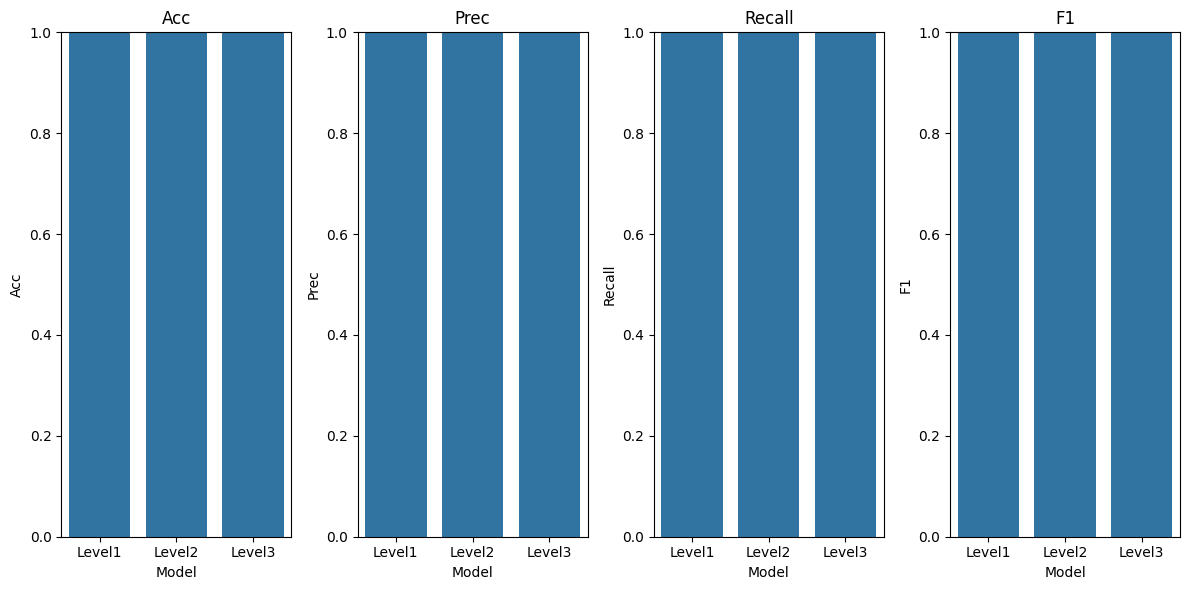

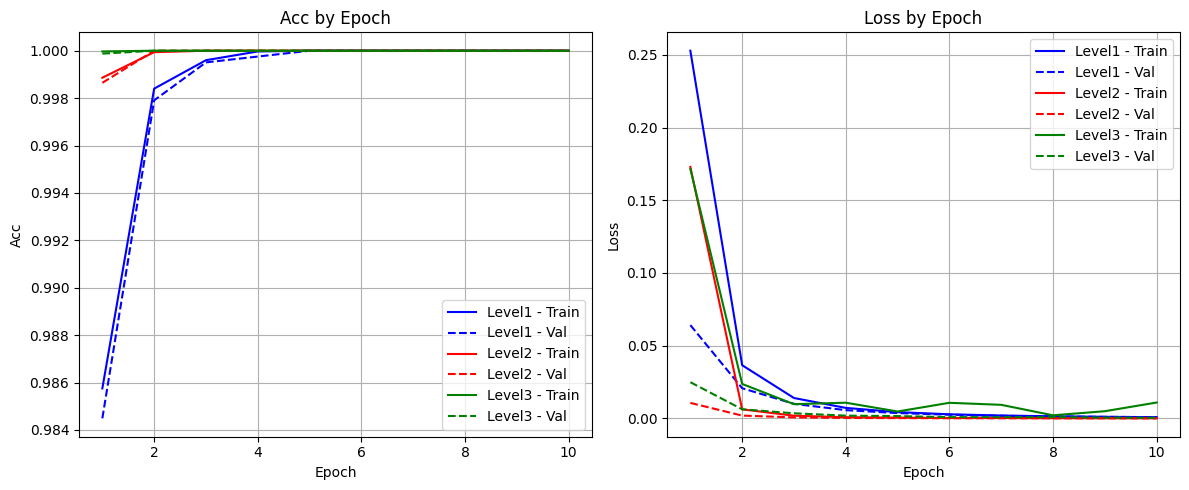


Ep 1 Stats
    Model   Val Acc      Prec    Recall        F1
0  Level1  0.984490  0.990072  0.982255  0.986118
1  Level2  0.998646  0.999239  0.997413  0.998324
2  Level3  0.999877  1.000000  0.998980  0.999489

Ep 2 Stats
    Model   Val Acc      Prec    Recall        F1
0  Level1  0.997907  0.999231  0.996622  0.997922
1  Level2  1.000000  0.999752  1.000000  0.999876
2  Level3  1.000000  1.000000  1.000000  1.000000

Ep 3 Stats
    Model   Val Acc  Prec    Recall        F1
0  Level1  0.999508   1.0  0.999233  0.999616
1  Level2  1.000000   1.0  1.000000  1.000000
2  Level3  1.000000   1.0  1.000000  1.000000

Ep 4 Stats
    Model   Val Acc  Prec  Recall   F1
0  Level1  0.999754   1.0     1.0  1.0
1  Level2  1.000000   1.0     1.0  1.0
2  Level3  1.000000   1.0     1.0  1.0

Ep 5 Stats
    Model  Val Acc  Prec  Recall   F1
0  Level1      1.0   1.0     1.0  1.0
1  Level2      1.0   1.0     1.0  1.0
2  Level3      1.0   1.0     1.0  1.0

Ep 6 Stats
    Model  Val Acc  Prec  Recall   F

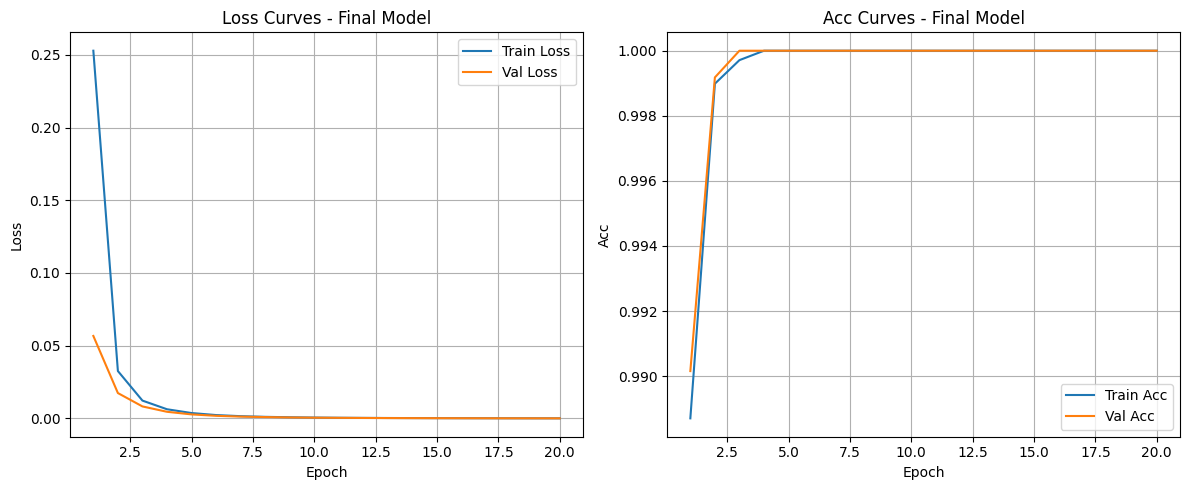

In [3]:
xT = torch.FloatTensor(X.values)
yT = torch.LongTensor(y)

inSz = X.shape[1]

sAcc, sPrc, sRec, sF1, sMtr = crossVal(
    Level1, xT, yT, inSz, nSp=5, nEp=10)

iAcc, iPrc, iRec, iF1, iMtr = crossVal(
    Level2, xT, yT, inSz, nSp=5, nEp=10)

cAcc, cPrc, cRec, cF1, cMtr = crossVal(
    Level3, xT, yT, inSz, nSp=5, nEp=10)

mdls = ['Level1', 'Level2', 'Level3']
accs = [sAcc, iAcc, cAcc]
prcs = [sPrc, iPrc, cPrc]
recs = [sRec, iRec, cRec]
f1s = [sF1, iF1, cF1]

compDf = pd.DataFrame({
    'Model': mdls,
    'Acc': accs,
    'Prec': prcs,
    'Recall': recs,
    'F1': f1s
})

compDf = compDf.sort_values('F1', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 6))
mtrs = ['Acc', 'Prec', 'Recall', 'F1']
for i, mtr in enumerate(mtrs):
    plt.subplot(1, 4, i+1)
    sns.barplot(x='Model', y=mtr, data=compDf)
    plt.title(mtr)
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

eps = list(range(1, 11))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eps, sMtr['trAc'], 'b-', label='Level1 - Train')
plt.plot(eps, sMtr['vlAc'], 'b--', label='Level1 - Val')
plt.plot(eps, iMtr['trAc'], 'r-', label='Level2 - Train')
plt.plot(eps, iMtr['vlAc'], 'r--', label='Level2 - Val')
plt.plot(eps, cMtr['trAc'], 'g-', label='Level3 - Train')
plt.plot(eps, cMtr['vlAc'], 'g--', label='Level3 - Val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc by Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(eps, sMtr['trLs'], 'b-', label='Level1 - Train')
plt.plot(eps, sMtr['vlLs'], 'b--', label='Level1 - Val')
plt.plot(eps, iMtr['trLs'], 'r-', label='Level2 - Train')
plt.plot(eps, iMtr['vlLs'], 'r--', label='Level2 - Val')
plt.plot(eps, cMtr['trLs'], 'g-', label='Level3 - Train')
plt.plot(eps, cMtr['vlLs'], 'g--', label='Level3 - Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

for ep in range(10):
    print(f"\nEp {ep+1} Stats")
    epTable = pd.DataFrame({
        'Model': ['Level1', 'Level2', 'Level3'],
        'Val Acc': [
            sMtr['vlAc'][ep], 
            iMtr['vlAc'][ep], 
            cMtr['vlAc'][ep]
        ],
        'Prec': [
            sMtr['prc'][ep],
            iMtr['prc'][ep],
            cMtr['prc'][ep]
        ],
        'Recall': [
            sMtr['rec'][ep],
            iMtr['rec'][ep],
            cMtr['rec'][ep]
        ],
        'F1': [
            sMtr['f1'][ep],
            iMtr['f1'][ep],
            cMtr['f1'][ep]
        ]
    })
    print(epTable)

allEpochsData = []
for ep in range(10):
    allEpochsData.append({
        'Ep': ep+1,
        'Model': 'Level1',
        'Val Acc': sMtr['vlAc'][ep],
        'Prec': sMtr['prc'][ep],
        'Recall': sMtr['rec'][ep],
        'F1': sMtr['f1'][ep]
    })
    
    allEpochsData.append({
        'Ep': ep+1,
        'Model': 'Level2',
        'Val Acc': iMtr['vlAc'][ep],
        'Prec': iMtr['prc'][ep],
        'Recall': iMtr['rec'][ep],
        'F1': iMtr['f1'][ep]
    })
    
    allEpochsData.append({
        'Ep': ep+1,
        'Model': 'Level3',
        'Val Acc': cMtr['vlAc'][ep],
        'Prec': cMtr['prc'][ep],
        'Recall': cMtr['rec'][ep],
        'F1': cMtr['f1'][ep]
    })

allEpochsDF = pd.DataFrame(allEpochsData)
print("\nFull Model Stats across all Epchs")
print(allEpochsDF)

pivotTable = allEpochsDF.pivot_table(
    index='Ep', 
    columns='Model', 
    values=['Val Acc', 'Prec', 'Recall', 'F1']
)
print("\nPivot tble")
print(pivotTable)

epComp = []

for ep in range(10):
    epComp.append({
        'Ep': ep + 1,
        'Level1 Train Acc': sMtr['trAc'][ep],
        'Level1 Val Acc': sMtr['vlAc'][ep],
        'Level2 Train Acc': iMtr['trAc'][ep],
        'Level2 Val Acc': iMtr['vlAc'][ep],
        'Level3 Train Acc': cMtr['trAc'][ep],
        'Level3 Val Acc': cMtr['vlAc'][ep]
    })

epDf = pd.DataFrame(epComp)

winMdl = compDf.iloc[0]['Model']

if winMdl == 'Level1':
    wMdl = Level1(inSz)
elif winMdl == 'Level2':
    wMdl = Level2(inSz)
else:
    wMdl = Level3(inSz)

xTrF = torch.cat((xTrT, xVlT), 0)
yTrF = torch.cat((yTrT, yVlT), 0)

crt = nn.BCELoss()
opt = optim.Adam(wMdl.parameters(), lr=0.001)

trLs, vlLs, trAcs, vlAcs = trainMod(
    wMdl, xTrF, yTrF, 
    xVlT, yVlT, crt, opt, nEp=20)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(trLs) + 1), trLs, label='Train Loss')
plt.plot(range(1, len(vlLs) + 1), vlLs, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves - Final Model')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(trAcs) + 1), trAcs, label='Train Acc')
plt.plot(range(1, len(vlAcs) + 1), vlAcs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curves - Final Model')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

tsAcc, tsPrc, tsRec, tsF1 = evalMod(wMdl, xTsT, yTsT)

def cntParams(mdl):
    return sum(p.numel() for p in mdl.parameters() if p.requires_grad)

sMdl = Level1(inSz)
iMdl = Level2(inSz)
cMdl = Level3(inSz)

sumTbl = pd.DataFrame({
    'Model': ['Level1', 'Level2', 'Level3'],
    'Architecture': [
        '1 hidden', 
        '2 hidden with dropout', 
        '3 hidden with batch norm'
    ],
    'Params': [
        cntParams(sMdl),
        cntParams(iMdl),
        cntParams(cMdl)
    ],
    'Final Acc': [sAcc, iAcc, cAcc],
    'Final F1': [sF1, iF1, cF1],
    'Acc @ Ep 5': [
        sMtr['vlAc'][4], 
        iMtr['vlAc'][4], 
        cMtr['vlAc'][4]
    ],
    'Train Speed': ['Fast', 'Medium', 'Slow']
})

My process + other unanswered or unclear elements:

See all results detailed in the plots + print out tables above.

Best model: While all the models eventually achieve perfection in terms of accuracy, recall, and precision, the second metric to define the best performance by is the effiency by which those numbers were achieved, and that goes to the level 3 model which was the most complex model. It achieved the highest numbers in terms of those metrics faster (in terms of epochs) than either of the other 2 models. This is likely to be attributed to the batch normalization I added along with the droput (though this was also present in level2, but you can see a huge difference between level2 and level1)

In actual numbers, level3 achieved perfect accuracy by epoch 2, level2 took until epoch 3, and level1 took until epoch 6. I used the BCEloss function is its best in situations where there is either a 0 and 1 to be used to classify an element (binary classification tasks). 

See table for comparison in the output for each epoch with each model.

In terms of activiation, all utilzied ReLU be see key differences here: Level1 (simplest) uses ReLU activation after a single hidden layer and Sigmoid at the output layer. Level2 (mid way, less simple) applies ReLU after each of two hidden layers with dropout (0.2) following the first ReLU activation. Sigmoid at the output. Level3 (most complex) implements ReLU after each of three hidden layers with batch normalization preceding each ReLU activation, dropout (0.3) following the first two ReLU activations. Sigmoid at the output layer.




## Before You Submit...

00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.